# Finding the dimensionality of Dataset
First we need to import some libraries and configure plotting style to begin the analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import pandas
import sys
sys.path.append('../src/')
from diffusion_maps_tools import *
# Matplotlib setup
plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')

In [2]:
filename = 'input.xlsx'
input_array = np.array(pandas.read_excel(filename, skiprows=2).iloc[:, 1:])
print('The shape of input array is {}'.format(input_array.shape))

The shape of input array is (999, 7)


## Scaling the data
Here we project data on 2D axis (two of parameters) to see how is the distribution of data, to see whether we need scale them or not.

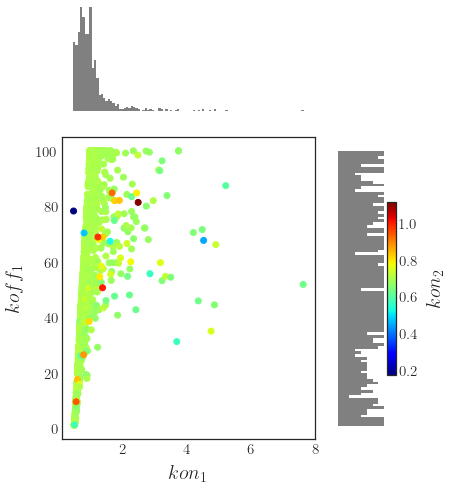

In [3]:
# Which parameters we want to plot
# x_axis = lab1
# y_axis = lab2
# color  = lab3
# bins = number of bins for histogram
lab1 = 0
lab2 = 2
lab3 = 1
bins = 100

fig = plt.figure(figsize=(16, 6))
# define the axis for the first plot
left, width = 0.1, 0.22
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.25]
rect_histy = [left_h, bottom, 0.05, height]
ax = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

sp = ax.scatter(input_array[:,lab1], 
                input_array[:,lab2],
                c = input_array[:,lab3],
                cmap='jet')

ax_histx.set_ylim(ax.get_ylim());
ax_histx.hist(input_array[:,lab1], bins=bins, color='grey');
ax_histx.axis('off');

ax_histy.set_xlim(ax.get_xlim());
ax_histy.hist(input_array[:,lab2], 
              orientation='horizontal',
              bins=bins, color='grey');
ax_histy.axis('off');

ax.set_xlabel(r'$kon_1$');
ax.set_ylabel(r'$koff_1$');
cb = plt.colorbar(sp);
cb.set_label(r'$kon_2$')

### Well seems that data is not so nicely distributed
- First I standardize input space by removing the mean and scaling to unit variance.
- Second I normalized all data in [-1,1] range

### Let's look at standardize version first

In [4]:
stan_scaler = StandardScaler().fit(input_array)
input_stan = stan_scaler.transform(input_array)

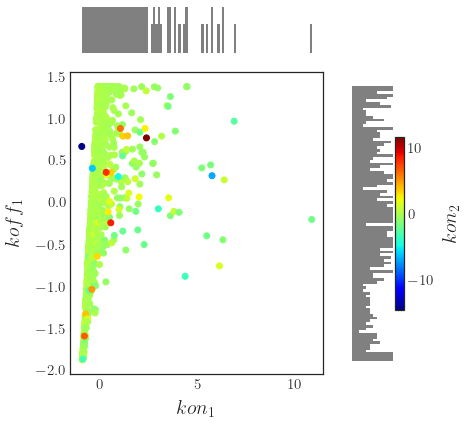

In [5]:
fig = plt.figure(figsize=(16, 6))
# define the axis for the first plot
left, width = 0.1, 0.22
bottom, height = 0.1, 0.7
bottom_h = height
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.25]
rect_histy = [left_h, bottom, 0.05, height]
ax = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

sp = ax.scatter(input_stan[:,lab1], 
                input_stan[:,lab2],
                c = input_stan[:,lab3],
                cmap='jet')

ax_histx.set_ylim(ax.get_ylim());
ax_histx.hist(input_stan[:,lab1], bins=bins, color='grey');
ax_histx.axis('off');

ax_histy.set_xlim(ax.get_xlim());
ax_histy.hist(input_stan[:,lab2], 
              orientation='horizontal',
              bins=bins, color='grey');
ax_histy.axis('off');

ax.set_xlabel(r'$kon_1$');
ax.set_ylabel(r'$koff_1$');
cb = plt.colorbar(sp);
cb.set_label(r'$kon_2$');

### And then apply the Min Max scaling to bring everythin in [-1,1] range

In [6]:
minmax_scaler = MinMaxScaler(feature_range=(-1,1)).fit(input_stan)
input_scaled = minmax_scaler.transform(input_stan)

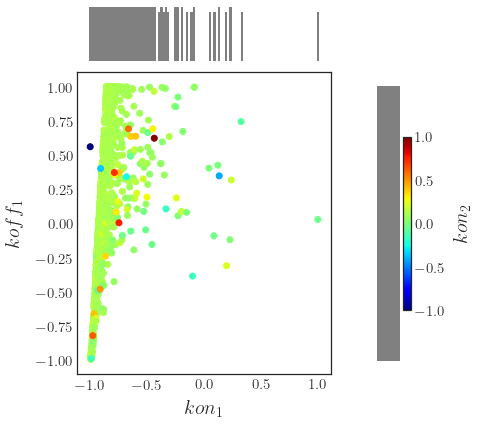

In [7]:
fig = plt.figure(figsize=(16, 6))
# define the axis for the first plot
left, width = 0.1, 0.22
bottom, height = 0.1, 0.7
bottom_h = height
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.25]
rect_histy = [left_h, bottom, 0.05, height]
ax = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

sp = ax.scatter(input_scaled[:,lab1], 
                input_scaled[:,lab2],
                c = input_scaled[:,lab3],
                cmap='jet')

ax_histx.set_ylim(ax.get_ylim());
ax_histx.hist(input_scaled[:,lab1], bins=bins, color='grey');
ax_histx.axis('off');

ax_histy.set_xlim(ax.get_xlim());
ax_histy.hist(input_scaled[:,lab2], 
              orientation='horizontal',
              bins=bins, color='grey');
ax_histy.axis('off');

ax.set_xlabel(r'$kon_1$');
ax.set_ylabel(r'$koff_1$');
cb = plt.colorbar(sp);
cb.set_label(r'$kon_2$');

**Looks ready for Diffusion Maps analysis now**
- We used all data in distance matrix since 1000 points is
practical on normal machines.
- The kernel width is $\epsilon=5$.

# Seems that we have some serious outliers.
# We need to clean data more carefully.

  > Dataset: 999 points in 7 dimensions
  > Compute distances with pdist
  --> Distance matrix is 100.0000% dense.
  > Compute Kernel
  > Compute Normalized Kernel with alpha=1.000000
  > Compute First 5 Eigenvectors
    Eigenvalues are = [1.         0.12312871 0.0762847  0.01967594 0.0085072 ]


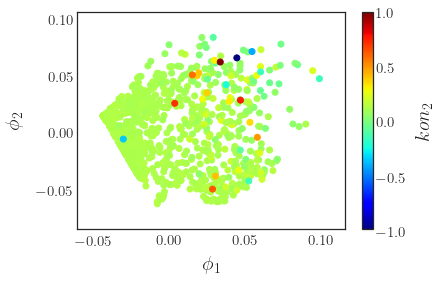

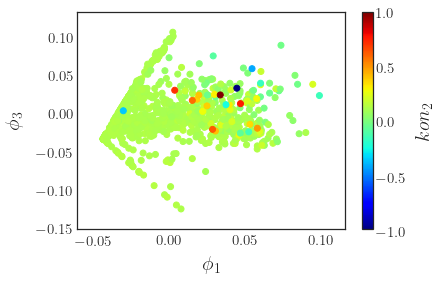

In [8]:
DiffMaps = diffusion_maps_tools()
num_eigenpairs = 5
epsilon = 5
distance = DiffMaps.distance(points = input_scaled)
kernel = DiffMaps.kernel(metric = distance, epsilon=epsilon*2)
kernel = DiffMaps.ker_normalize(kernel, alpha=1.0)
eigval, phi = DiffMaps.eigensolver(matrix = kernel,
                                   num_eigenpairs = num_eigenpairs)
print('    Eigenvalues are = {}'.format(eigval.real))

# plot some eigenvectors and color by kon_2
for i in range(3, num_eigenpairs):
    plt.figure()
    ax = plt.subplot(111)
    p = ax.scatter(phi[:,1],
                   phi[:,i-1], 
                   c= input_scaled[:,lab3],
                   cmap= 'jet')
    ax.set_xlabel(r'$\phi_1$')
    ax.set_ylabel(r'$\phi_{}$'.format(i-1))
    cbar = plt.colorbar(p)
    cbar.set_label(r'$kon_2$')

  > Dataset: 999 points in 1 dimensions
  > Compute distances with pdist
  --> Distance matrix is 99.9972% dense.
  > Compute Kernel
  > Compute Normalized Kernel with alpha=1.000000
  > Compute First 5 Eigenvectors
    Eigenvalues are = [ 1.         -0.00100298 -0.00100298 -0.00100298 -0.00100298]


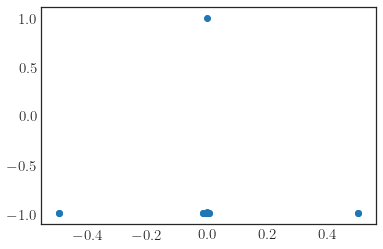

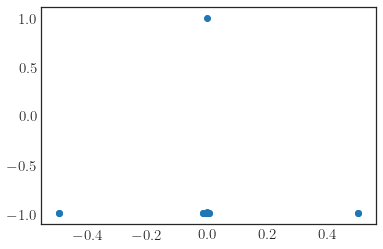

In [22]:
DiffMaps = diffusion_maps_tools()
num_eigenpairs = 5
epsilon = 100
distance = DiffMaps.distance(points = np.c_[input_scaled[:,-1]])
kernel = DiffMaps.kernel(metric = distance, epsilon=epsilon*2)
kernel = DiffMaps.ker_normalize(kernel, alpha=1.0)
eigval, phi = DiffMaps.eigensolver(matrix = kernel,
                                   num_eigenpairs = num_eigenpairs)
print('    Eigenvalues are = {}'.format(eigval.real))

# plot some eigenvectors and color by kon_2
for i in range(3, num_eigenpairs):
    plt.figure()
    ax = plt.subplot(111)
    p = ax.scatter(phi[:,1], input_scaled[:,-1])

### Values of the last column is not well distributed